In [22]:
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt

In [23]:
import matplotlib as mpl
fontsize = 14
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 1.5
#rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize' % axis] = fontsize-2
    rcparams['%stick.direction' % axis] = 'in'
    rcparams['%stick.major.size' % axis] = 5.5
    rcparams['%stick.minor.size' % axis] =  3.5
    rcparams['%stick.major.width' % axis] = 2
    rcparams['%stick.minor.width' % axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
# set up the plotting params
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [24]:
# setup the outdir - where plots will be saved
outdir = '/pscratch/sd/u/uendert/mocks_restuls/y1_full_shape/double_blinded/nCov/figs/'
os.makedirs(outdir, exist_ok=True)

In [25]:
def get_blind_cosmo(type, zmin, zmax, w0_blind=-0.90, wa_blind=0.26, fiducial_f=0.8):
    # NB: Blinded parameters values used for the double-blinded analysis: w0_blind=-0.90, wa_blind=0.26, and fnl=20.
    # Constants
    tp2z = {'LRG': 0.8, 'ELG': 1.1, 'QSO': 1.6,'BGS': 0.25}
    tp2bias = {'LRG': 2., 'ELG': 1.3, 'QSO': 2.3,'BGS':1.8}
    
    # ztp = z
    ztp = tp2z[type[:3]]
    bias = tp2bias[type[:3]]

    # Compute f_blind     
    from cosmoprimo.fiducial import DESI
    cosmo_fid = DESI()
    cosmo_shift = cosmo_fid.clone(w0_fld=w0_blind, wa_fld=wa_blind)
    DM_fid = cosmo_fid.comoving_angular_distance(ztp)
    DH_fid = 1. / cosmo_fid.hubble_function(ztp)
    DM_shift = cosmo_shift.comoving_angular_distance(ztp)
    DH_shift = 1. / cosmo_shift.hubble_function(ztp)
    vol_fac =  (DM_shift**2 * DH_shift) / (DM_fid**2 * DH_fid)
    a = 0.2 / bias**2
    b = 2 / (3 * bias)
    c = 1 - (1 + 0.2 * (fiducial_f / bias)**2. + 2/3 * fiducial_f / bias) / vol_fac
    f_blind = (-b + np.sqrt(b**2. - 4.*a*c))/(2*a)
    dfper = (f_blind - fiducial_f)/fiducial_f
    maxfper = 0.1
    if abs(dfper) > maxfper:
        dfper = maxfper*dfper/abs(dfper)
        f_blind = (1+dfper)*fiducial_f
    
    from cosmoprimo.fiducial import DESI
    cosmo = fiducial = DESI()

    ztp = (zmax+zmin)/2.
    print("=====================================")
    print(f"ztp: {ztp}")
    cosmo = fiducial.clone(w0_fld=w0_blind, wa_fld=wa_blind)
    qpar = cosmo.efunc(ztp) / fiducial.efunc(ztp)
    qper = fiducial.comoving_angular_distance(ztp) / cosmo.comoving_angular_distance(ztp)
    qiso = (qpar * qper**2)**(1/3)
    qap = qpar / qper
    df = f_blind / fiducial_f

    return dict(qpar=qpar, qper=qper, df=df, dm=0., qiso=qiso, qap=qap)


In [26]:
from desilike.samples import plotting, Chain
from getdist import plots

# desilike
def process_chains(chain_dirs=os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'double_blinded'),
                   observable='corr', tracer=['LRG1'],
                   templates=['shapefit', 'shapefit-qisoqap', 'shapefit-qisoqap-prior']
                ):
    # set up zmin, zmax for this tracer
    zmin, zmax = {'LRG1': [0.4, 0.6], 'LRG2': [0.6, 0.8], 'LRG3': [0.8, 1.1],
                   'ELG1':[0.8, 1.1], 'ELG2': [1.1, 1.6],
                   'QSO1': [0.8, 2.1],
                   'BGS1': [0.1, 0.4]
                   
                   }[tracer]

    # modify the names to be what the files have
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso' + tracer[-1]
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.5' + tracer[-1]
    
    # expexted values due to the double blinding shift 
    ref_values = get_blind_cosmo(tracer[:-1], zmin=zmin, zmax=zmax)
    print(f"Expected shift: {ref_values}")
    
    # misc
    chain_dirs = np.array(chain_dirs)
    template = templates[0]
    templates_readin = []

    # load in the chains
    chains = []
    labels = []
    for chain_dir in chain_dirs:
        print(f'reading chains for {chain_dir} .. ')


        print(os.path.join(chain_dir, 'chain_{}_{}_{}_{}_velocileptors_{}_0.npy'.format(tracer[:-1], zmin, zmax, observable, template,)))
        if os.path.exists(os.path.join(chain_dir, 'chain_{}_{}_{}_{}_velocileptors_{}_0.npy'.format(tracer[:-1], zmin, zmax, observable, template,))):
            chain = Chain.concatenate([Chain.load(os.path.join(chain_dir,
                                                            'chain_{}_{}_{}_{}_velocileptors_{}_{:d}.npy'.format(tracer[:-1], zmin, zmax, observable, template,
                                                                                                                    i))).remove_burnin(0.5)[::20] for i in range(8)])
            chain = chain.sample_solved()
            if 'nCov' in outdir:
                print(chain_dir)
                print(chain_dir.split('/')[-1])
                print(chain_dir.split('/')[-2])
                                
                chains.append(chain.to_getdist(label= chain_dir.split('/')[-1] if 'nCov' not in chain_dir else chain_dir.split('/')[-2]+'_'+chain_dir.split('/')[-1]))
                labels.append(chain_dir.split('/')[-1] if 'nCov' not in chain_dir else chain_dir.split('/')[-2]+'_'+chain_dir.split('/')[-1])
            else:
                chains.append(chain.to_getdist(label=chain_dir.split('/')[-1]))
                labels.append(chain_dir.split('/')[-1])
            # templates_readin.append(template)
        else:
            print(f'chain for {chain_dir} not found')

    # now plot - first the full thing, with all params
    fname = 'plot_posteriors-allparams_{}_{}_{}_{}_velocileptors_{}templates.png'.format(tracer[:-1], zmin, zmax, observable, len(templates_readin))
    if not os.path.exists(os.path.join(f'{outdir}/{fname}')):
        colors = ['#7f7f7f', '#1f77b4', '#ff7f0e']
        # ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        plt.clf()
        g = plots.get_subplot_plotter()
        g.settings.alpha_filled_add = 0.8
        g.settings.title_limit_fontsize = 20
        g.settings.axes_labelsize = 20
        g.settings.legend_fontsize = 20
        g.triangle_plot(chains, analysis_settings={'ignore_rows': 0.3},
                        filled=False, contour_lws=[1, 2],
                        contour_colors=colors,
                        # markers={"qiso":1., "qap":1., "df":1., "dm":0.}, marker_args={'ls': '-'},
                        )
        plt.tight_layout()
        plt.suptitle(f"{tracer[:-1]}: [{zmin},{zmax}]", fontweight="bold", y=1.05, fontsize=20)
        fname = 'plot_posteriors-allparams_{}_{}_{}_{}_velocileptors_{}templates.png'.format(tracer[:-1], zmin, zmax, observable, len(templates_readin))
        plt.savefig(f'{outdir}/{fname}', format='png', bbox_inches='tight')
        print(f'saved {fname}')
        plt.show()

    # now plot only interested in params
    # colors = ['#7f7f7f', '#1f77b4', '#ff7f0e']
    #colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']
    colors = ['#FF7F0E', '#1F77B4', '#2CA02C']
    plt.clf()
    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add = 0.8
    g.settings.title_limit_fontsize = 20
    g.settings.axes_labelsize = 20
    g.settings.legend_fontsize = 20
    g.settings.line_labels = False
    g.triangle_plot(chains, params=["qiso", "qap", "df", "dm"], analysis_settings={'ignore_rows': 0.3},
                    filled=False, contour_lws=[1, 2, 2],
                    contour_colors=colors,
                    #markers={"qiso":1., "qap":1., "df":1., "dm":0.}, marker_args={'ls': '-'},
                    )
    
    # now create legend
    from matplotlib.lines import Line2D
    lw = 2
    legends = []
    for i in range(len(chains)):
        legends.append(Line2D([0], [0], color=colors[i], lw=lw, label=labels[i], linestyle='-'))
        
    # Add reference values to the plot
    # Diagonal subplots
    ax_qiso = g.subplots[0, 0]
    ax_qap = g.subplots[1, 1]
    ax_df = g.subplots[2, 2]
    ax_dm = g.subplots[3, 3]
    
    color = '#1F77B4' # if 'nCov' not in outdir else '#FF7F0E'
    label = 'expected shift'
    linestyle = '--'

    # add vline to the diagonals
    ax_qiso.axvline(ref_values["qiso"], color=color, linestyle=linestyle)
    ax_qap.axvline(ref_values["qap"], color=color, linestyle=linestyle)
    ax_df.axvline(ref_values["df"], color=color, linestyle=linestyle)
    ax_dm.axvline(ref_values["dm"], color=color, linestyle=linestyle)
    
    # Off-diagonal subplots
    ax_qiso_qap = g.subplots[1, 0]
    ax_qiso_df = g.subplots[2, 0]
    ax_qiso_dm = g.subplots[3, 0]
    ax_qap_df = g.subplots[2, 1]
    ax_qap_dm = g.subplots[3, 1]
    ax_df_dm = g.subplots[3, 2]

    # Mark reference points on off-diagonal subplots

    for ax, x, y in [
        (ax_qiso_qap, ref_values["qiso"], ref_values["qap"]),
        (ax_qiso_df, ref_values["qiso"], ref_values["df"]),
        (ax_qiso_dm, ref_values["qiso"], ref_values["dm"]),
        (ax_qap_df, ref_values["qap"], ref_values["df"]),
        (ax_qap_dm, ref_values["qap"], ref_values["dm"]),
        (ax_df_dm, ref_values["df"], ref_values["dm"])
    ]:
        #ax.plot(x, y, 'r*', markersize=10, label='Expected')  # Add the label here
        ax.axhline(y, linestyle=linestyle, color=color)
        ax.axvline(x, linestyle=linestyle, color=color)
        
        
    legends.append(Line2D([0], [0], color=color, lw=lw, linestyle=linestyle, label=label))
    plt.gcf().legend(handles=legends, fontsize=18, bbox_to_anchor=(1,1))
    
    plt.tight_layout()
    plt.suptitle(f"{tracer[:-1]}: [{zmin},{zmax}]", fontweight="bold", y=1.05, fontsize=20)
    fname = 'plot_posteriors-qiso-qap-dm-df_{}_{}_{}_{}_velocileptors_{}templates.png'.format(tracer[:-1], zmin, zmax, observable, len(templates_readin))
    plt.savefig(f'{outdir}/{fname}', format='png', bbox_inches='tight')
    print(f'saved {fname}')
    plt.show()


    # now plot only some
    if 'shapefit-qisoqap' in templates_readin and 'shapefit-qisoqap-prior' in templates_readin:
        ind1 = np.where(templates == 'shapefit-qisoqap')[0][0]
        ind2 = np.where(templates == 'shapefit-qisoqap-prior')[0][0]

        plt.clf()
        g = plots.get_subplot_plotter()
        g.settings.alpha_filled_add = 0.8
        g.settings.title_limit_fontsize = 14
        g.settings.axes_labelsize = 14
        g.settings.legend_fontsize = 14
        g.settings.axes_fontsize = 14
        g.triangle_plot([chains[ind1],chains[ind2]], params=["qiso", "qap", "df", "dm"],
                        analysis_settings={'ignore_rows': 0.3}, title_limit=2,
                        markers={"qiso":1., "qap":1., "df":1., "dm":0.}, marker_args={'ls': '-'},
                        filled=False, contour_lws=[3],
                        contour_colors=[colors[ind1], colors[ind2]]
                        )
        plt.tight_layout()
        plt.suptitle(f"{tracer[:-1]}: [{zmin},{zmax}]", fontweight="bold")
        fname = 'plot_posteriors-4params_{}_{}_{}_{}_velocileptors_2templates.png'.format(tracer[:-1], zmin, zmax, observable)
        plt.savefig(f'{outdir}/{fname}', format='png', bbox_inches='tight')
        print(f'saved {fname}')
        plt.show()

############################################################
plotting things for LRG1
ztp: 0.5
Expected shift: {'qpar': 1.037416033742422, 'qper': 1.0205701459498924, 'df': 1.1, 'dm': 0.0, 'qiso': 1.026154826109796, 'qap': 1.016506349768688}
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.4_0.6_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded
single_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.4_0.6_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded
double_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/nCov .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/nC

/tmp/ipykernel_1886397/3893103142.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-allparams_LRG_0.4_0.6_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

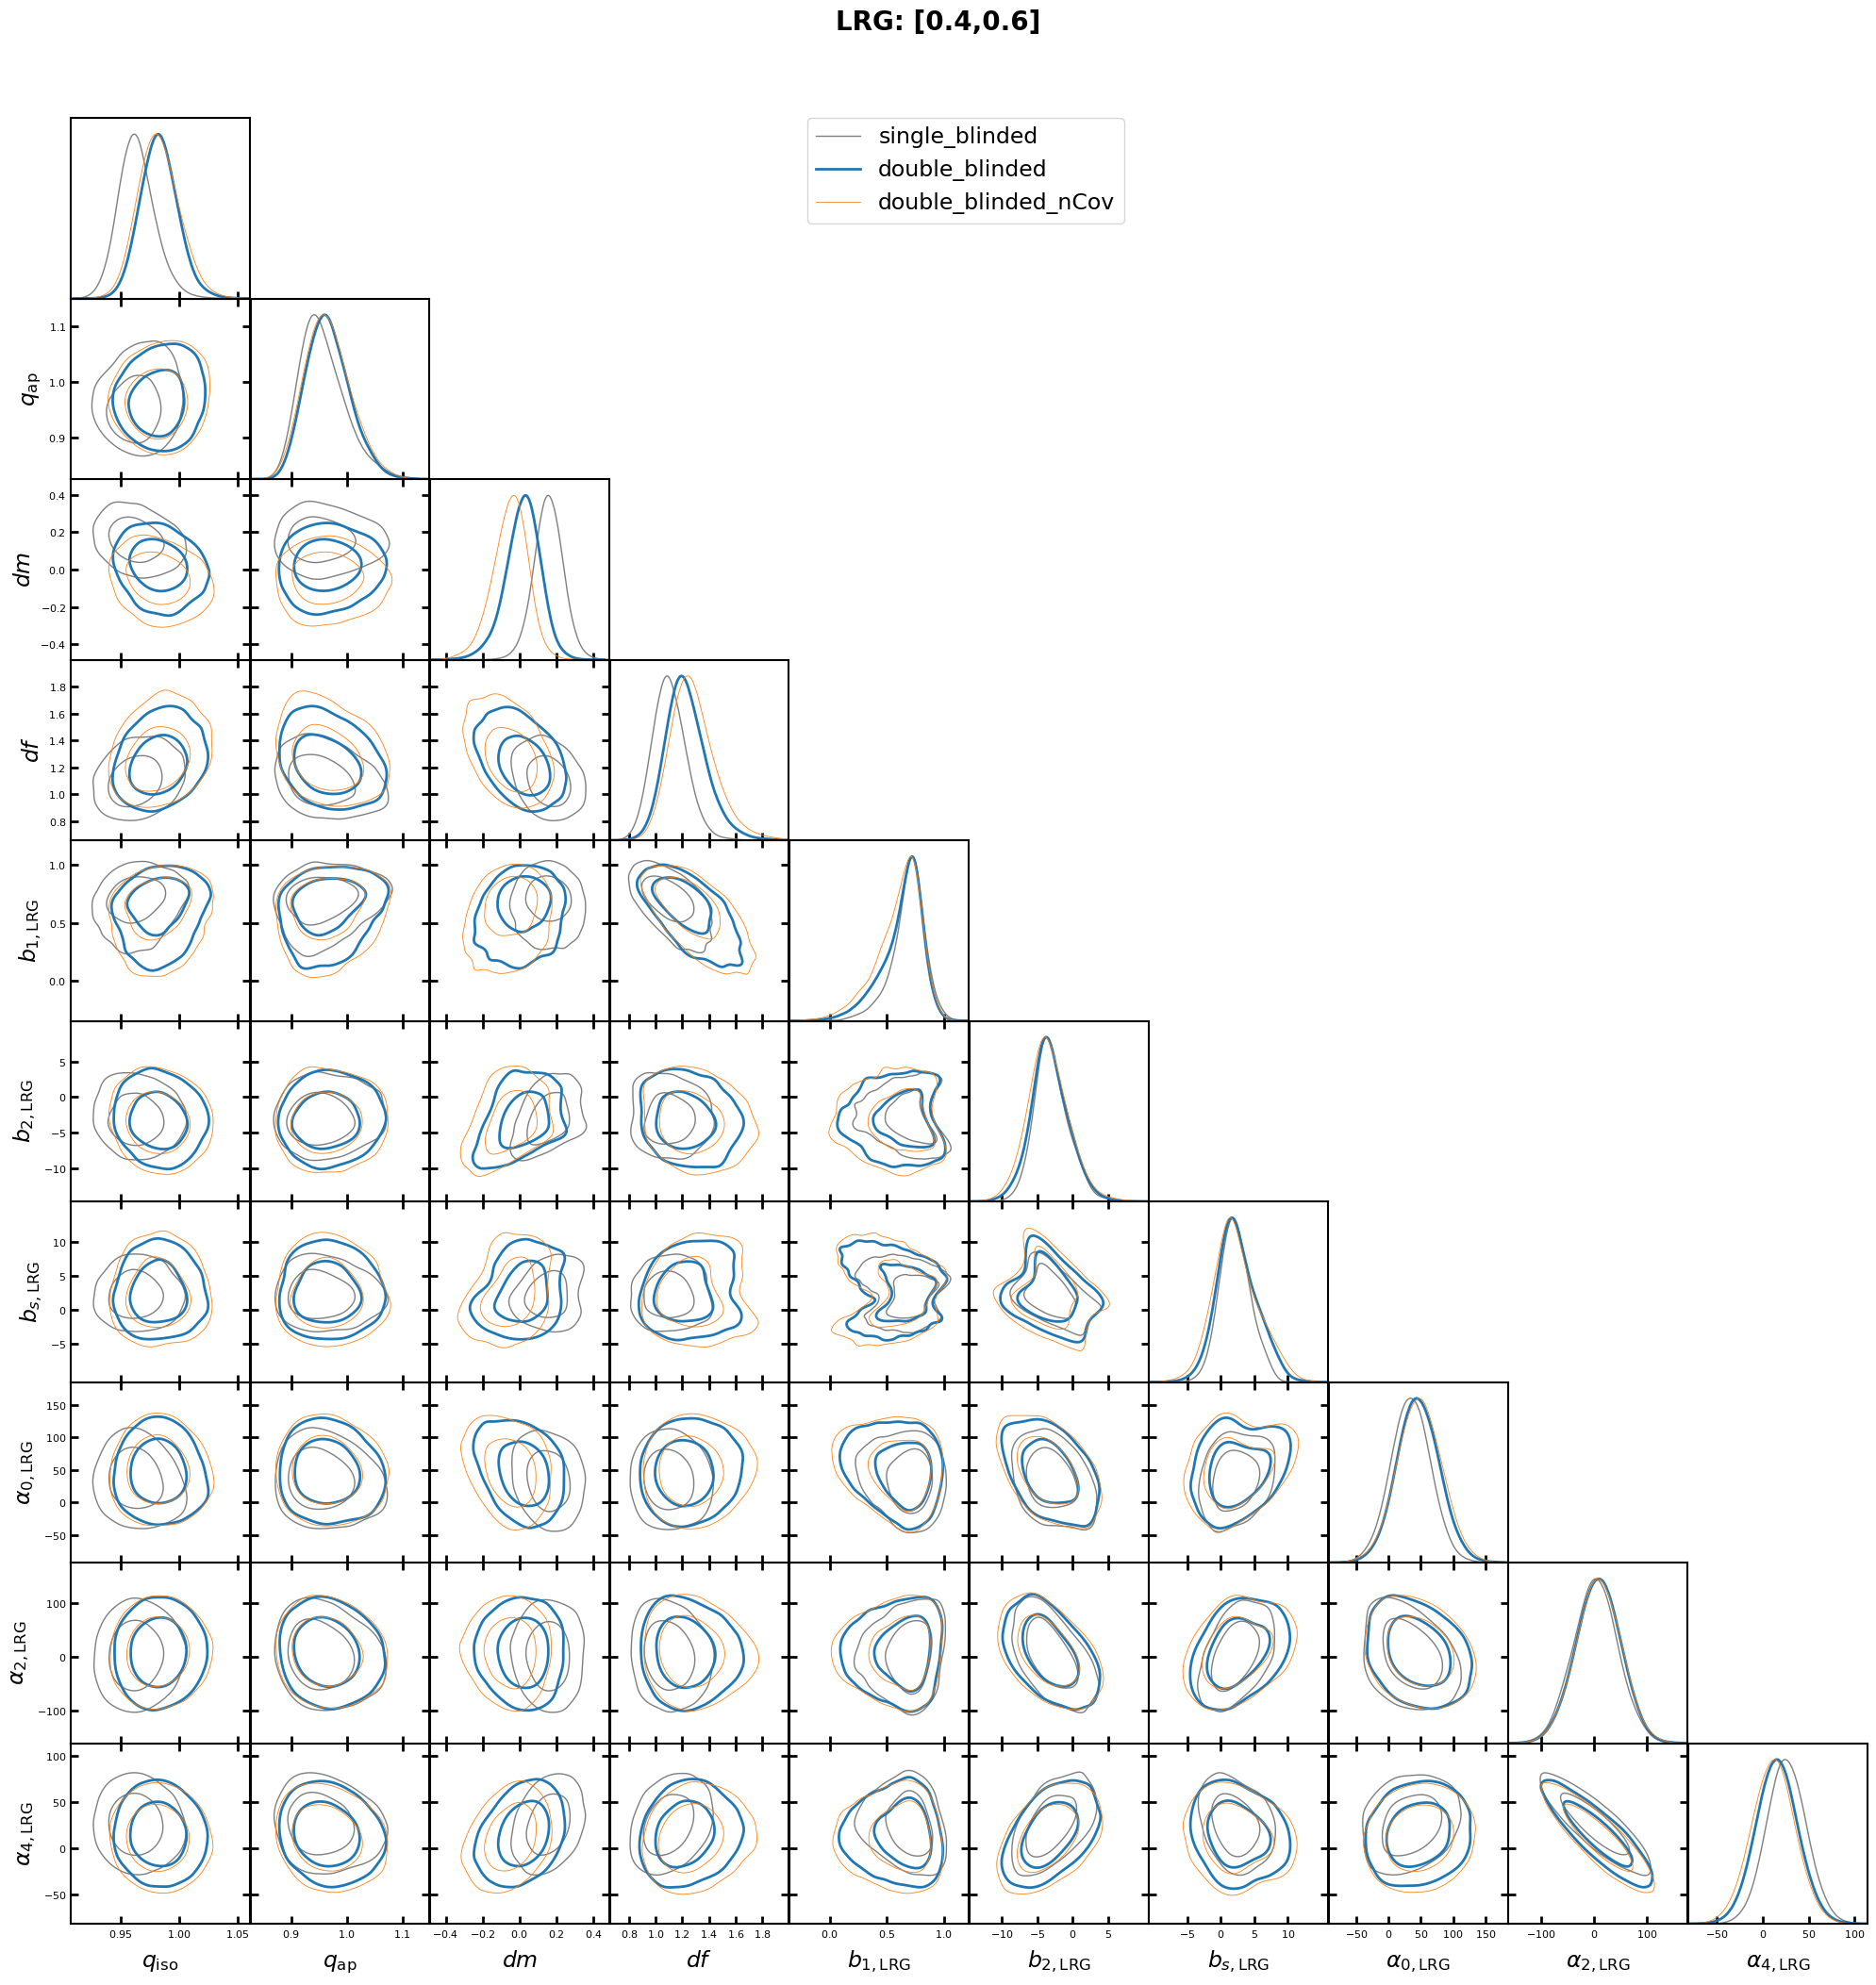

/tmp/ipykernel_1886397/3893103142.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-qiso-qap-dm-df_LRG_0.4_0.6_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

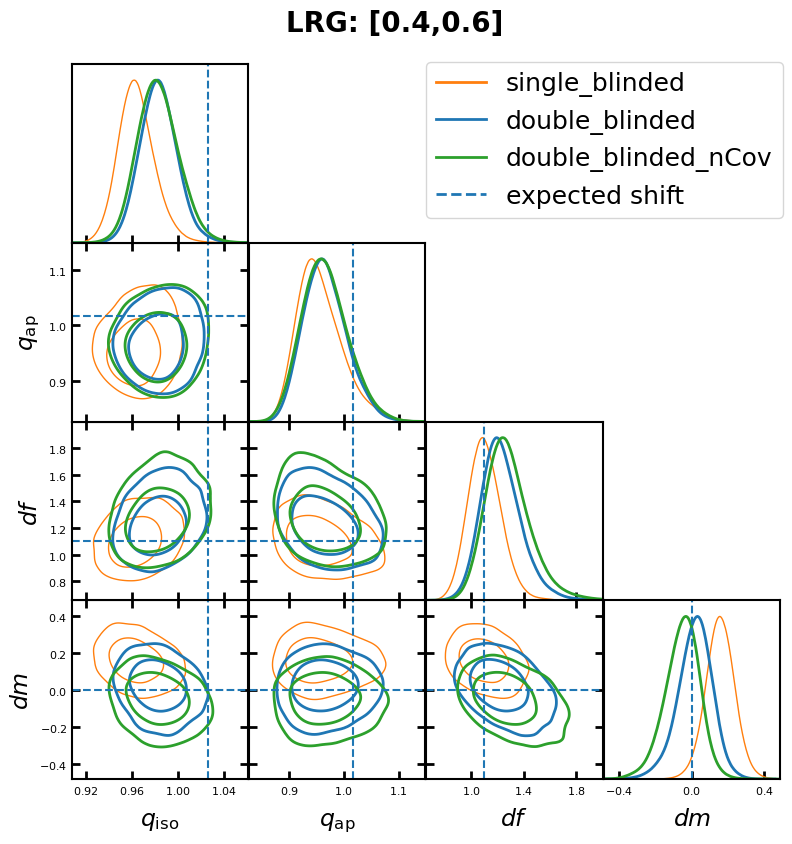

############################################################


############################################################
plotting things for LRG2
ztp: 0.7
Expected shift: {'qpar': 1.0429797166411068, 'qper': 1.0253829894145665, 'df': 1.1, 'dm': 0.0, 'qiso': 1.0312153281422698, 'qap': 1.0171611265334009}
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.6_0.8_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded
single_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.6_0.8_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded
double_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/nC

/tmp/ipykernel_1886397/3893103142.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-allparams_LRG_0.6_0.8_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

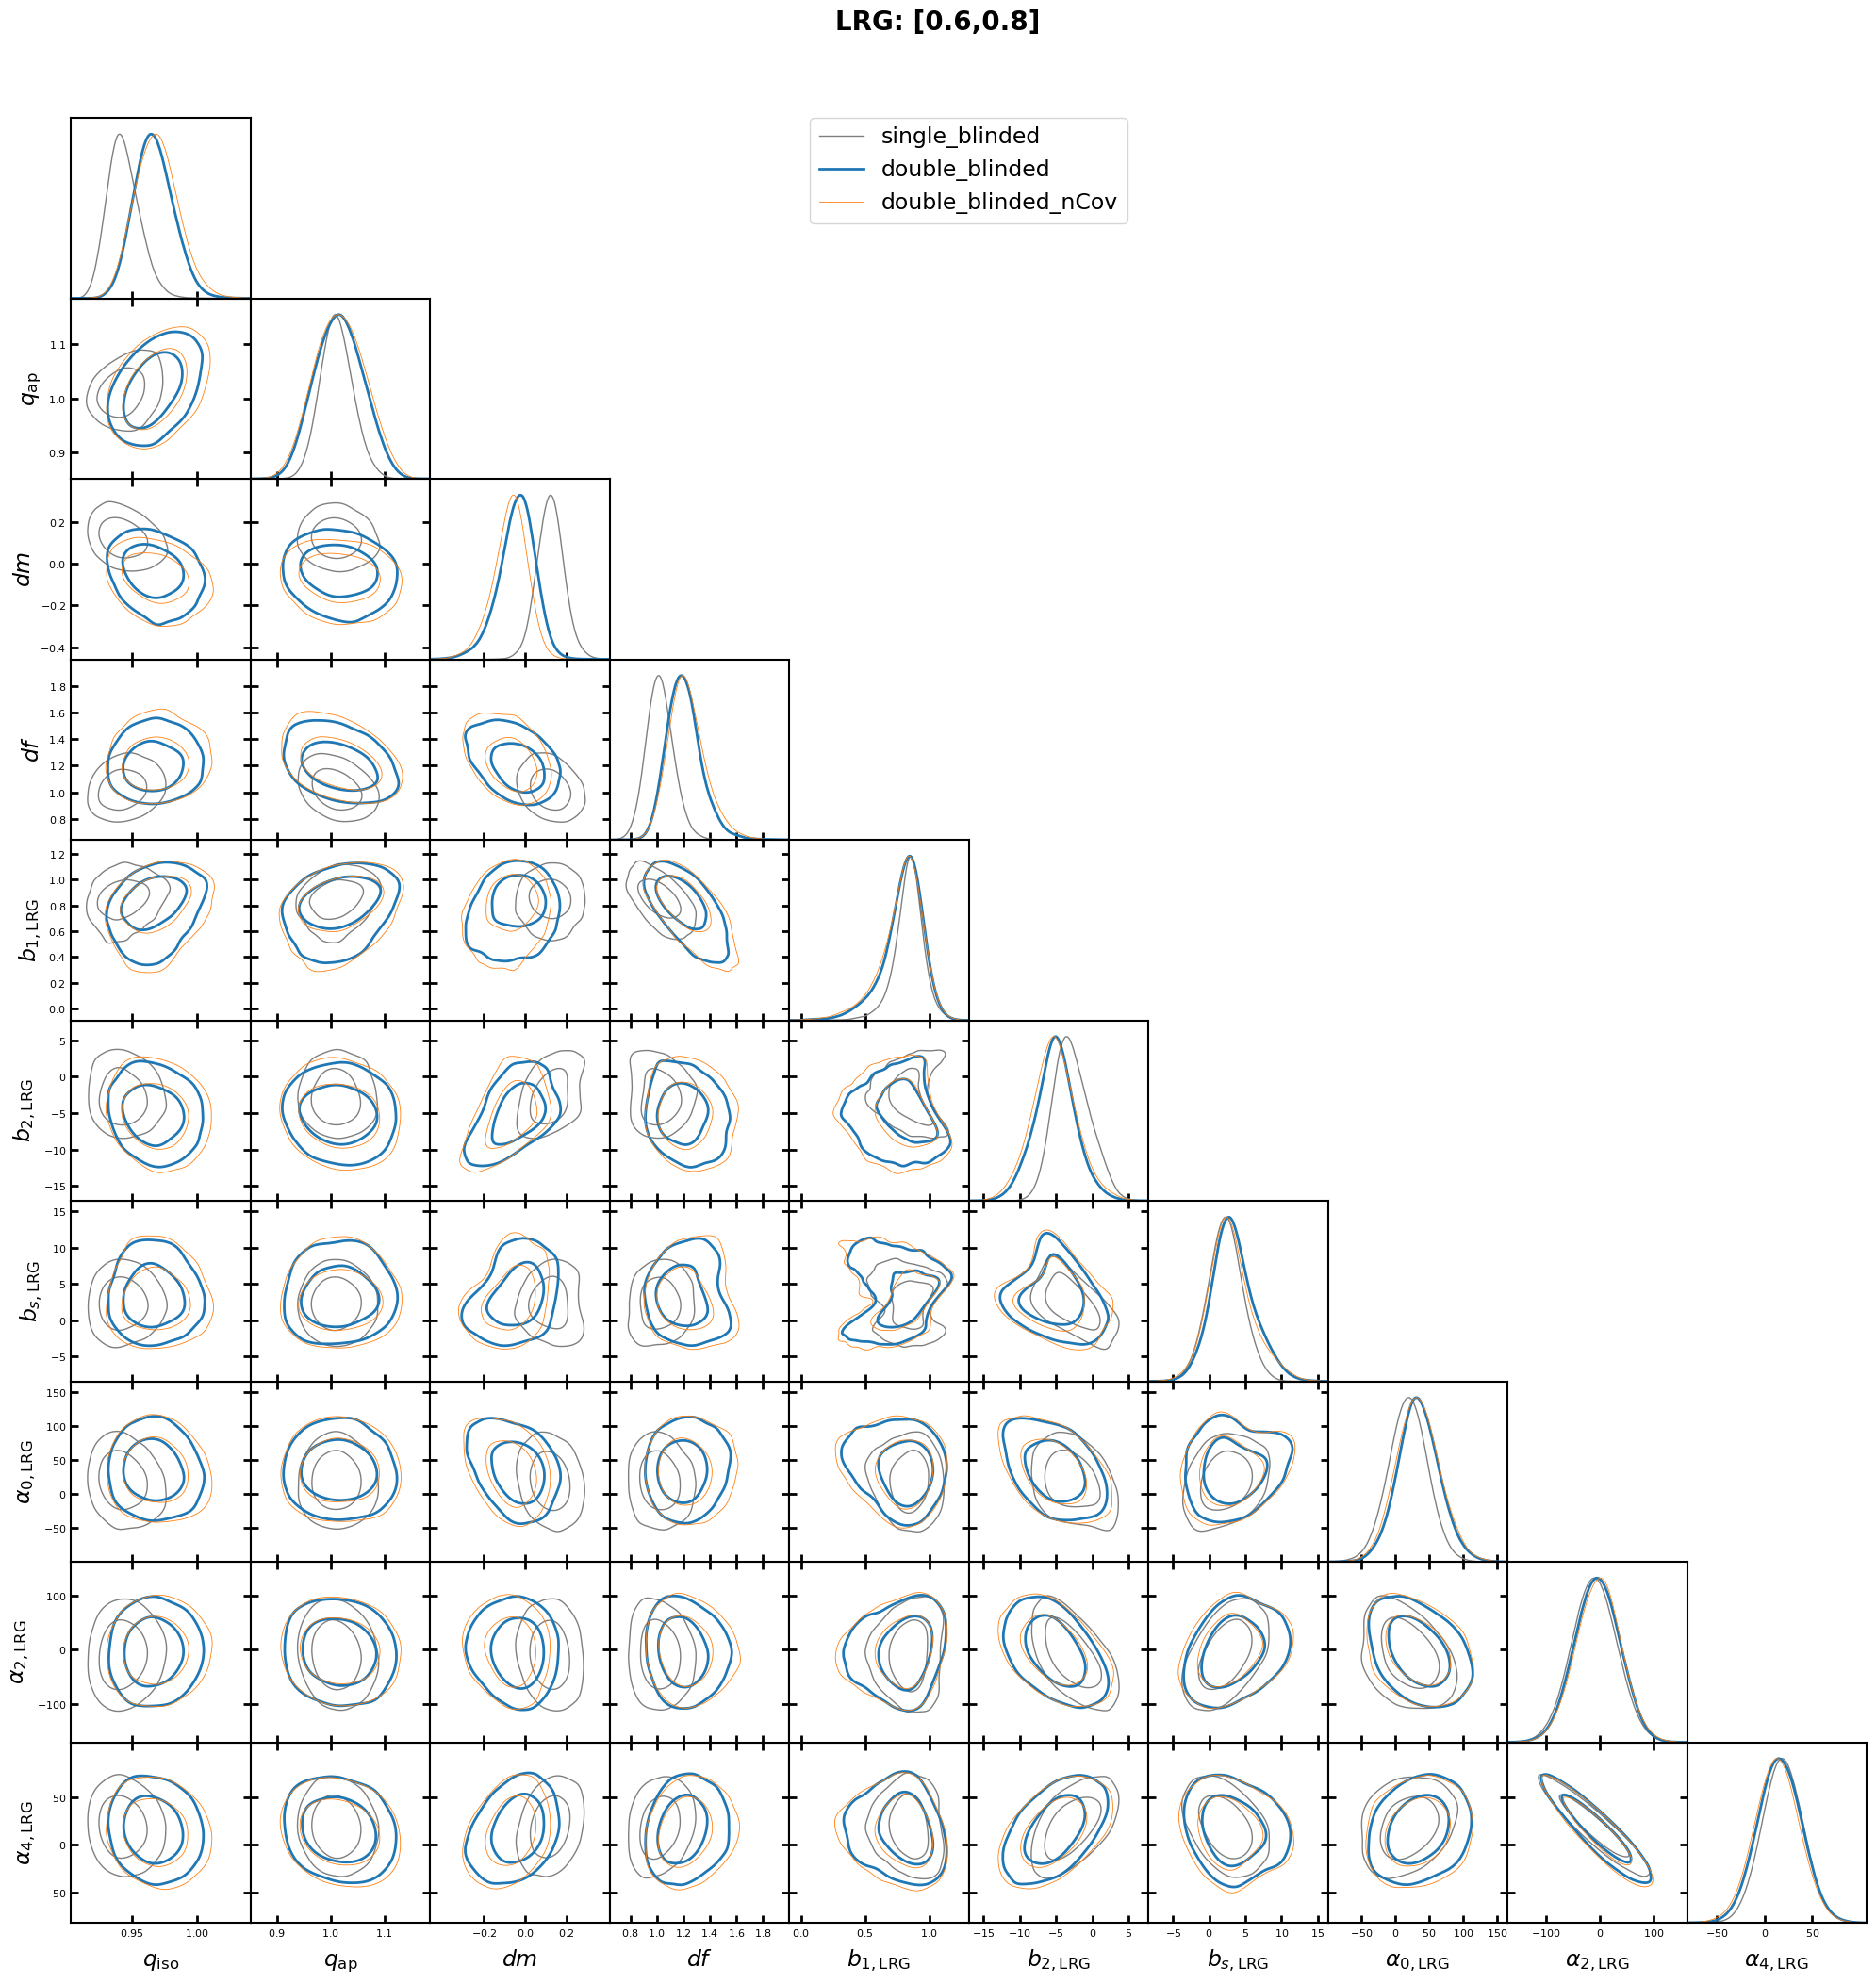

/tmp/ipykernel_1886397/3893103142.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-qiso-qap-dm-df_LRG_0.6_0.8_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

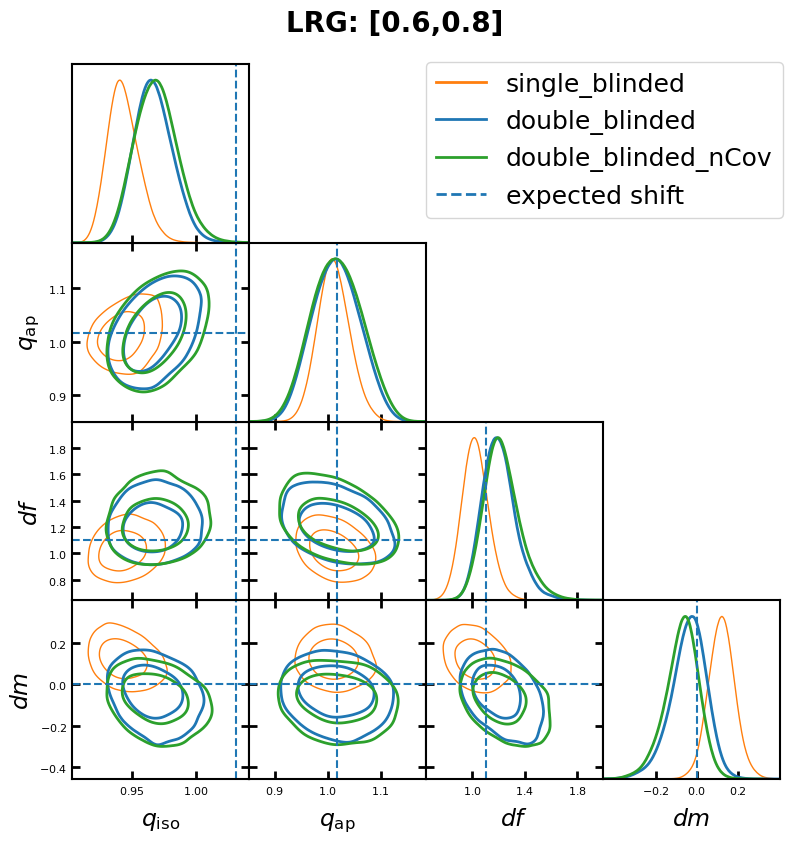

############################################################


############################################################
plotting things for LRG3
ztp: 0.9500000000000001
Expected shift: {'qpar': 1.0450470492377948, 'qper': 1.0293206611811896, 'df': 1.1, 'dm': 0.0, 'qiso': 1.0345363177141143, 'qap': 1.0152784148319325}
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.8_1.1_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded
single_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.8_1.1_corr_velocileptors_shapefit-qisoqap_0.npy
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded
double_blinded
test_y1_full_shape
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/do

/tmp/ipykernel_1886397/3893103142.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-allparams_LRG_0.8_1.1_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

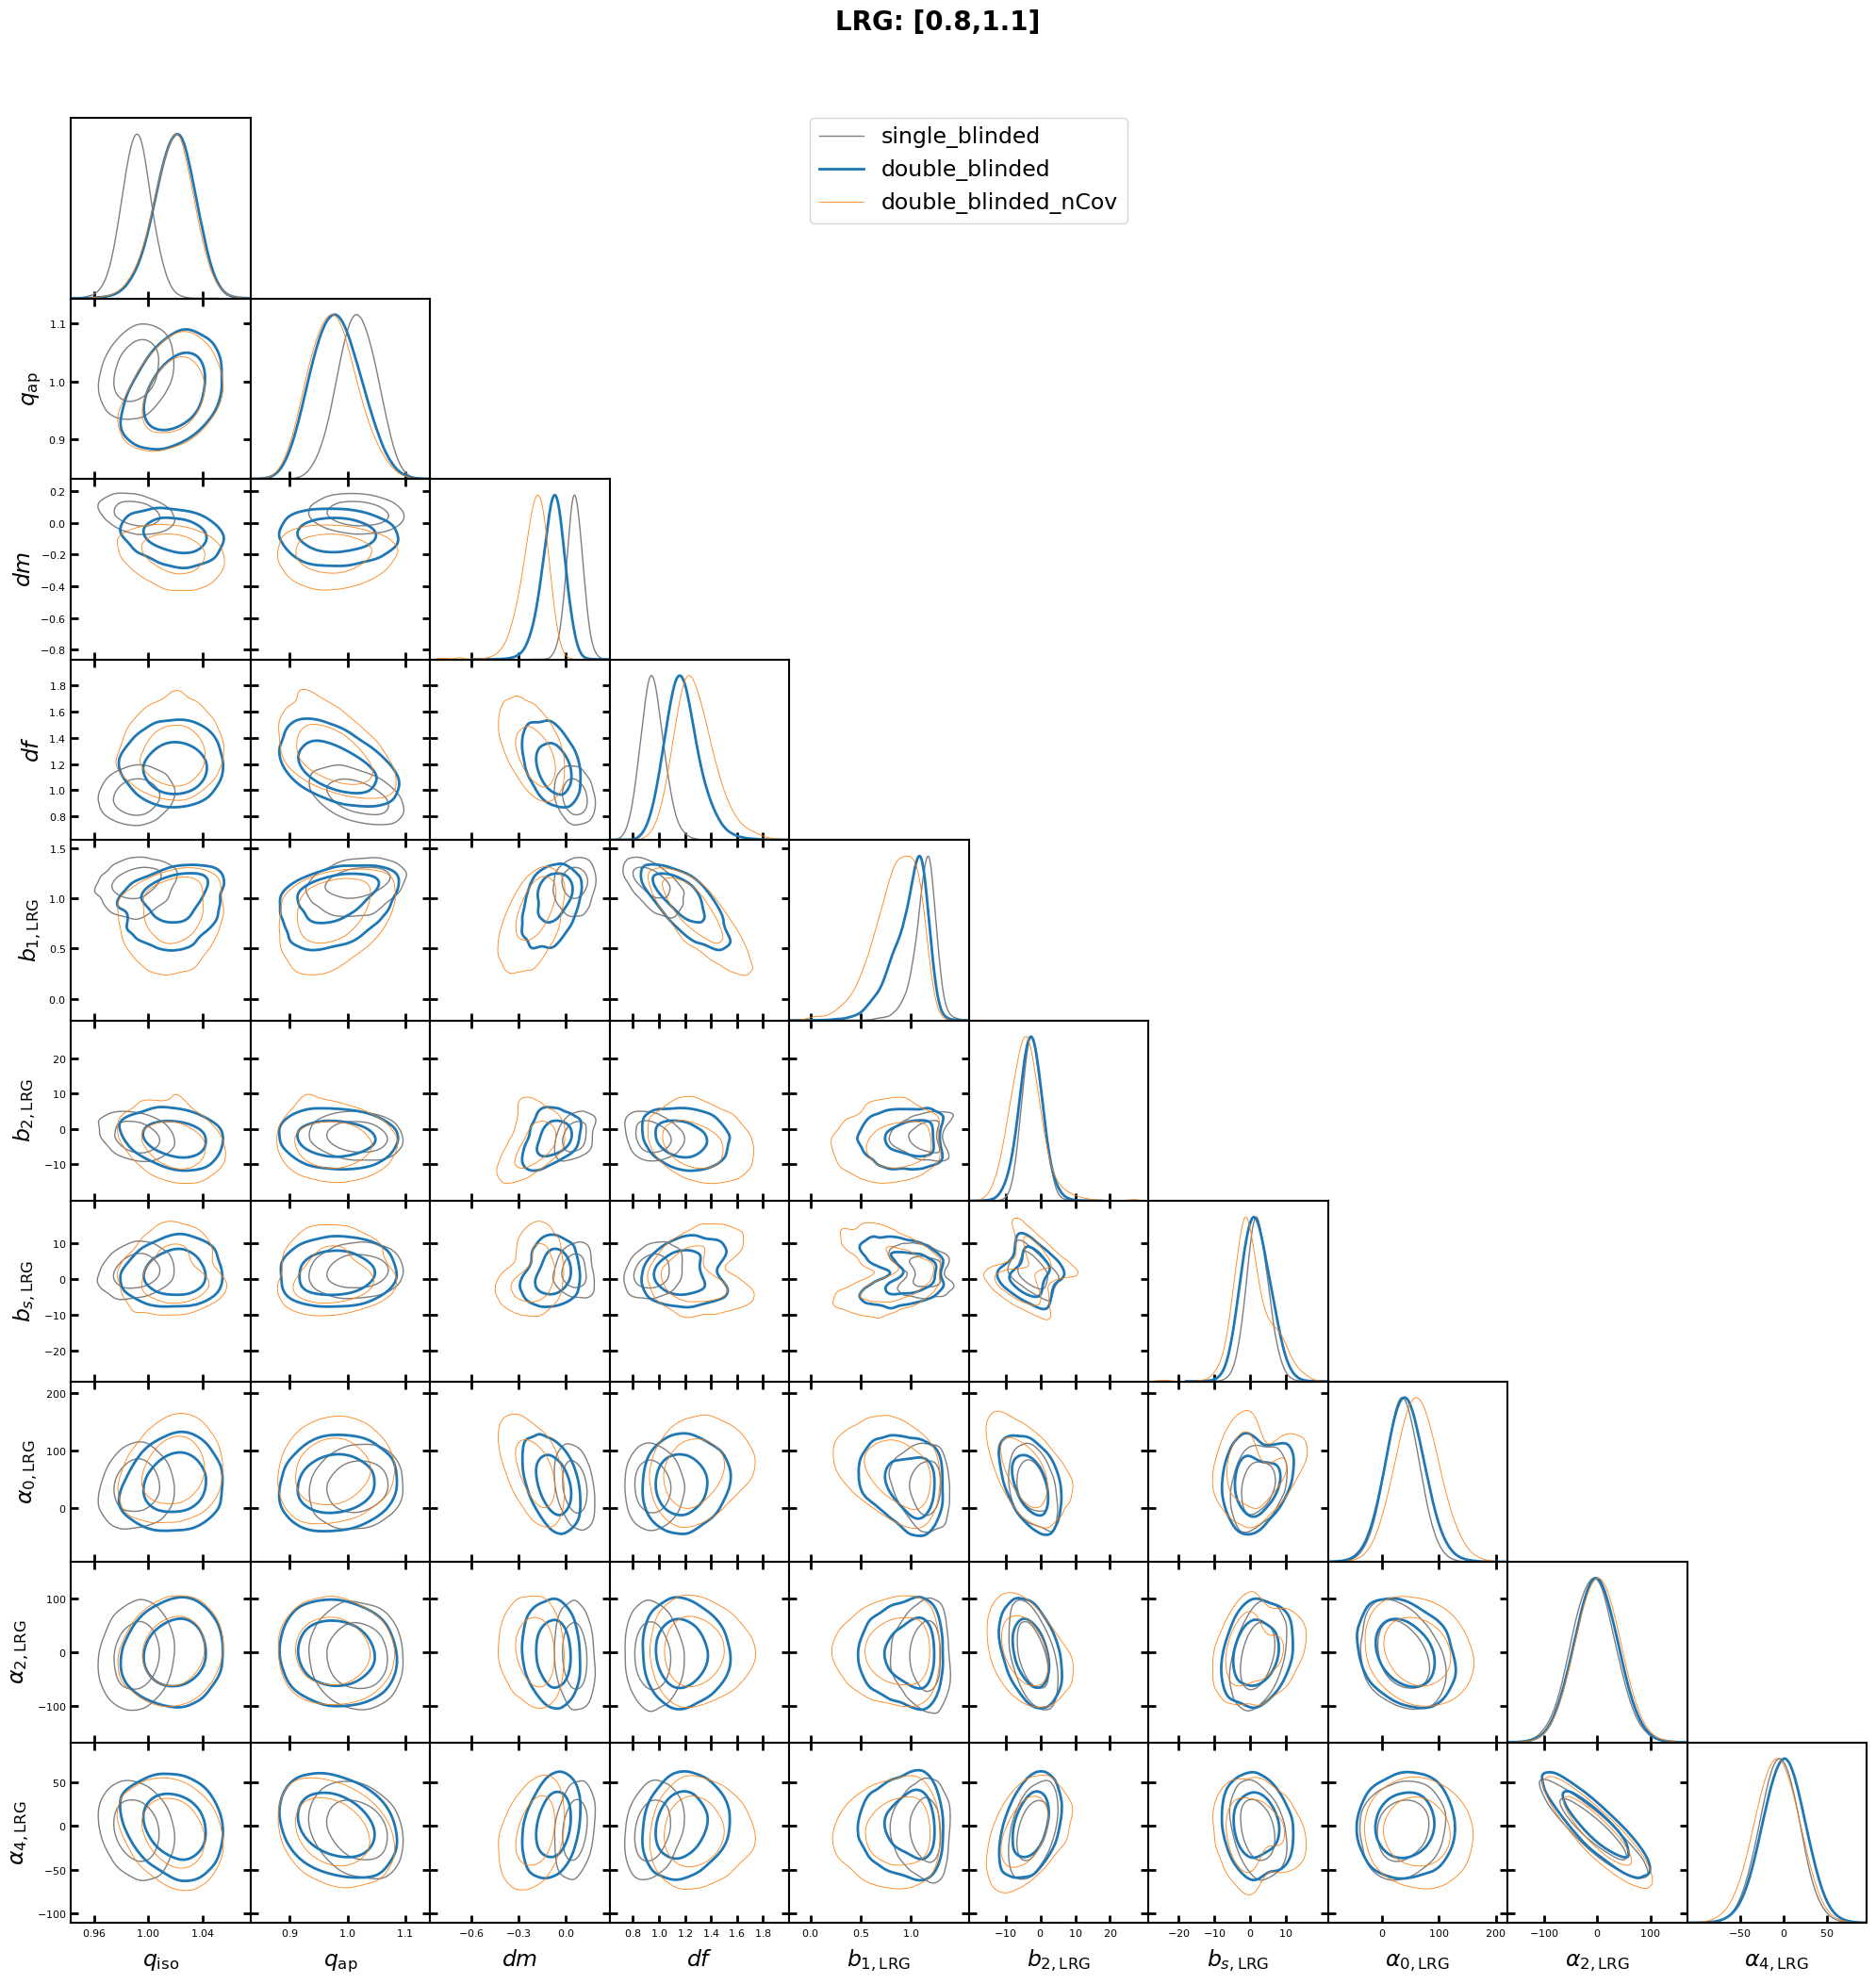

/tmp/ipykernel_1886397/3893103142.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors-qiso-qap-dm-df_LRG_0.8_1.1_corr_velocileptors_0templates.png


<Figure size 1000x600 with 0 Axes>

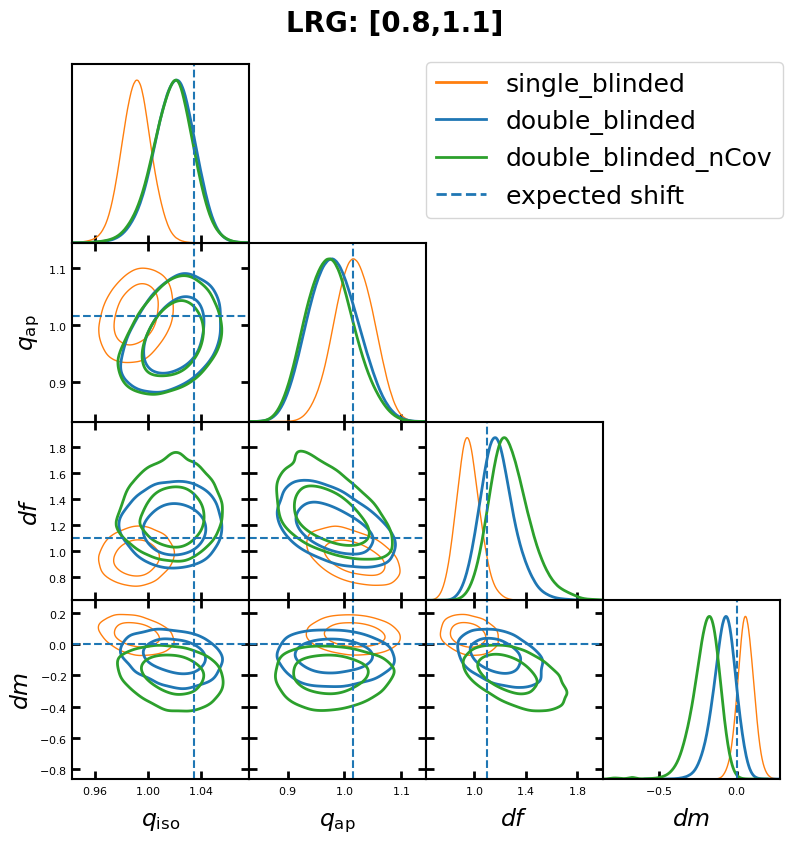

############################################################


CPU times: user 10min 56s, sys: 31min, total: 41min 56s
Wall time: 2min 30s


In [27]:
%%time

for tracer in ['LRG1', 'LRG2', 'LRG3']:
   print('############################################################')
   print(f'plotting things for {tracer}')
   process_chains(chain_dirs=[os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'single_blinded'), 
   os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'double_blinded'),
   os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'double_blinded', 'nCov')],
                   observable='corr', tracer=tracer,
                   templates=['shapefit-qisoqap']
                )
   print('############################################################\n\n')

misc

In [28]:

#g = plots.get_subplot_plotter()

#?g.settings
#?g.triangle_plot